This notebook is for bulk data model construction.

In [2]:
import numpy as np
from scipy.stats import spearmanr, logistic, t as tstat
from statsmodels.stats.multitest import multipletests
from scipy.special import expit, logit
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from glob import glob
import os
import h5py
from scipy.stats import pearsonr
from utils.utils import plot_root_intervals, get_max

pd.set_option('display.max_columns', 150)

In [3]:
path = 'clock_data/proc_data.csv'
df = pd.read_csv(path, index_col=0)

In [5]:
files = sorted(glob('clock_data/GSE120132_RAW/*.txt'))
newcols = []
for f in files:
    for d in df.columns:
        if d in f:
            name = os.path.basename(f).split('_')[0]
            newcols.append(name)
df.columns = newcols

In [7]:
df.head()

,GSM3394172,GSM3394173,GSM3394174,GSM3394175,GSM3394176,GSM3394177,GSM3394178,GSM3394179,GSM3394180,GSM3394181,GSM3394182,GSM3394183,GSM3394184,GSM3394185,GSM3394186,GSM3394187,GSM3394188,GSM3394189,GSM3394190,GSM3394191,GSM3394192,GSM3394193,GSM3394194,GSM3394195,GSM3394196,GSM3394197,GSM3394198,GSM3394199,GSM3394200,GSM3394201,GSM3394202,GSM3394203,GSM3394204,GSM3394205,GSM3394206,GSM3394207,GSM3394208,GSM3394209,GSM3394210,GSM3394211,GSM3394212,GSM3394213,GSM3394214,GSM3394215,GSM3394216,GSM3394217,GSM3394218,GSM3394219,GSM3394220,GSM3394221,GSM3394222,GSM3394223,GSM3394224,GSM3394225,GSM3394226,GSM3394227,GSM3394228,GSM3394229,GSM3394230,GSM3394231,GSM3394232,GSM3394233,GSM3394234,GSM3394235,GSM3394236,GSM3394237,GSM3394238,GSM3394239,GSM3394240,GSM3394241,GSM3394242,GSM3394243,GSM3394244,GSM3394245,GSM3394246,...,GSM3394646,GSM3394647,GSM3394648,GSM3394649,GSM3394650,GSM3394651,GSM3394652,GSM3394653,GSM3394654,GSM3394655,GSM3394656,GSM3394657,GSM3394658,GSM3394659,GSM3394660,GSM3394661,GSM3394662,GSM3394663,GSM3394664,GSM3394665,GSM3394666,GSM3394667,GSM3394668,GSM3394669,GSM3394670,GSM3394671,GSM3394672,GSM3394673,GSM3394674,GSM3394675,GSM3394676,GSM3394677,GSM3394678,GSM3394679,GSM3394680,GSM3394681,GSM3394682,GSM3394683,GSM3394684,GSM3394685,GSM3394686,GSM3394687,GSM3394688,GSM3394689,GSM3394690,GSM3394691,GSM3394692,GSM3394693,GSM3394694,GSM3394695,GSM3394696,GSM3394697,GSM3394698,GSM3394699,GSM3394700,GSM3394701,GSM3394702,GSM3394703,GSM3394704,GSM3394705,GSM3394706,GSM3394707,GSM3394708,GSM3394709,GSM3394710,GSM3394711,GSM3394712,GSM3394713,GSM3394714,GSM3394715,GSM3394716,GSM3394717,GSM3394718,GSM3394719,GSM3394720
ChrPos,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
chr1_3037825,0.927,1.000,0.986,0.935,0.985,0.923,1.000,0.985,0.949,0.952,0.978,0.963,0.984,0.945,0.88,0.964,0.944,0.941,1.000,0.932,0.979,0.976,0.891,0.935,1.000,1.000,0.976,0.944,0.979,0.909,0.963,0.971,0.942,0.925,0.966,0.969,NaN,0.953,0.971,0.988,NaN,0.96,1.00,1.000,0.972,NaN,0.953,0.974,0.948,1.000,1.00,0.942,1.000,0.966,0.980,0.959,0.933,0.957,0.904,0.989,0.953,1.0,1.0,NaN,NaN,1.0,1.000,NaN,NaN,0.970,0.929,0.952,1.000,0.984,0.974,...,1.000,0.95,0.941,NaN,0.970,1.000,1.000,0.964,0.95,NaN,0.958,NaN,NaN,0.931,0.967,0.972,1.000,NaN,1.0,1.000,1.000,1.000,1.0,0.906,NaN,1.000,NaN,1.0,0.96,1.00,0.958,1.000,0.962,0.967,1.000,NaN,0.964,0.94,NaN,NaN,1.000,NaN,1.000,NaN,1.000,NaN,0.974,0.939,0.972,0.891,1.000,1.000,1.000,NaN,0.947,0.971,0.947,0.974,NaN,NaN,1.00,0.912,1.0,NaN,NaN,0.938,1.0,NaN,0.952,1.000,NaN,0.946,0.933,NaN,0.925
chr1_3037853,0.878,0.922,0.845,0.891,0.864,0.962,0.951,0.926,0.949,0.903,0.923,0.963,0.934,0.927,0.98,0.911,0.963,0.941,0.958,0.909,0.979,NaN,0.957,0.935,0.953,0.933,1.000,NaN,0.875,NaN,0.963,0.897,0.986,0.955,NaN,0.938,NaN,0.897,0.917,0.881,NaN,NaN,1.00,0.892,0.972,NaN,0.977,0.975,0.828,0.921,0.98,1.000,0.965,0.949,0.918,0.898,0.853,0.943,0.945,0.955,0.977,1.0,1.0,NaN,NaN,NaN,0.947,NaN,NaN,0.955,0.976,1.000,0.930,0.917,0.987,...,0.955,NaN,0.942,1.0,0.939,0.884,0.969,1.000,NaN,1.0,NaN,NaN,NaN,0.963,1.000,0.889,1.000,NaN,1.0,0.945,0.955,0.947,1.0,0.906,1.000,0.923,NaN,1.0,0.96,0.94,NaN,0.911,0.923,0.933,1.000,0.970,0.929,0.94,NaN,0.96,NaN,0.923,0.947,1.000,1.000,0.958,0.974,NaN,0.889,0.913,0.926,0.952,0.952,0.974,0.947,NaN,0.947,0.974,0.96,NaN,0.96,0.970,1.0,1.00,NaN,0.970,NaN,1.000,0.952,0.909,NaN,0.929,1.000,NaN,0.950
chr1_3037855,0.976,0.980,0.915,0.978,0.985,0.962,0.951,0.956,1.000,0.950,0.978,1.000,0.967,0.964,1.00,0.947,0.981,0.941,NaN,0.977,0.979,0.902,0.956,0.935,1.000,0.956,0.976,0.972,0.979,0.939,1.000,0.970,0.957,0.985,NaN,0.969,NaN,0.953,0.972,1.000,1.00,1.00,1.00,1.000,0.943,1.000,0.930,0.975,0.948,0.921,0.98,0.962,0.947,0.983,0.980,1.000,0.947,0.957,0.932,1.000,0.977,NaN,NaN,NaN,NaN,1.0,0.947,NaN,NaN,0.955,0.952,1.000,0.982,0.967,0.934,...,0.955,NaN,0.962,1.0,0.939,0.977,0.969,1.000,1.00,NaN,NaN,NaN,1.0,1.000,1.000,0.

In [10]:
mpath = 'clock_data/GSE120132/GSE120132_metadata.csv'
meta = pd.read_csv(mpath, index_col=0)
meta[['Age', 'units']] = meta['characteristics_ch1.2.age'].str.split('mo', expand=True)
meta['Age'] = meta['Age'].astype(float)
meta.head(3)

,title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,taxid_ch1,characteristics_ch1.0.strain,characteristics_ch1.1.tissue,characteristics_ch1.2.age,characteristics_ch1.3.Sex,biomaterial_provider_ch1,molecule_ch1,extract_protocol_ch1,data_processing,platform_id,contact_name,contact_email,contact_laboratory,contact_department,contact_institute,contact_address,contact_city,contact_state,contact_zip/postal_code,contact_country,instrument_model,library_selection,library_source,library_strategy,relation,supplementary_file_1,series_id,data_row_count,Age,units
GSM3394172,Mouse_Adipose_SH001,GSM3394172,Public on Nov 29 2018,Sep 18 2018,Nov 29 2018,SRA,1,Adipose,Mus musculus,10090,C57BL/6J,Adipose,20mo,Female,UCLA,genomic DNA,(UCLA Data) For each sample 50-100 ng of purif...,All raw sequence files were processed using th...,GPL21103,"Steve,,Horvath",shorvath@mednet.ucla.edu,Horvath,Human Genetics,"University of California, Los Angeles","695 Charles E. Young Drive South, Box 708822",Los Angeles,CA,90095-7088,USA,Illumina HiSeq 4000,RANDOM,genomic,Bisulfite-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3394...,"GSE120132,GSE120137",0,20.0,
GSM3394173,Mouse_Adipose_SH002,GSM3394173,Public on Nov 29 2018,Sep 18 2018,Nov 29 2018,SRA,1,Adipose,Mus musculus,10090,C57BL/6J,Adipose,20mo,Female,UCLA,genomic DNA,(UCLA Data) For each sample 50-100 ng of purif...,All raw sequence files were processed using th...,GPL21103,"Steve,,Horvath",shorvath@mednet.ucla.edu,Horvath,Human Genetics,"University of California, Los Angeles","695 Charles E. Young Drive South, Box 708822",Los Angeles,CA,90095-7088,USA,Illumina HiSeq 4000,RANDOM,genomic,Bisulfite-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3394...,"GSE120132,GSE120137",0,20.0,
GSM3394174,Mouse_Adipose_SH003,GSM3394174,Public on Nov 29 2018,Sep 18 2018,Nov 29 2018,SRA,1,Adipose,Mus musculus,10090,C57BL/6J,Adipose,20mo,Female,UCLA,genomic DNA,(UCLA Data) For each sample 50-100 ng of purif...,All raw sequence files were processed using th...,GPL21103,"Steve,,Horvath",shorvath@mednet.ucla.edu,Horvath,Human Genetics,"University of California, Los Angeles","695 Charles E. Young Drive South, Box 708822",Los Angeles,CA,90095-7088,USA,Illumina HiSeq 4000,RANDOM,genomic,Bisulfite-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3394...,"GSE120132,GSE120137",0,20.0,


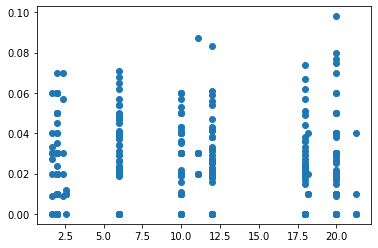

In [16]:
i = 113689
y = df.iloc[i]
y = y.dropna()
X = meta.loc[y.index]['Age']
plt.scatter(X, y)
plt.show()

### Linear Regression (Original Paper)

In [21]:
from tqdm import tqdm
from warnings import filterwarnings
from statsmodels.regression.linear_model import OLS

In [44]:
res = []
for i in tqdm(range(df.shape[0])):
    n = df.iloc[i].name
    y = df.iloc[i].dropna()
    X = meta.loc[y.index]['Age']
    y = np.where(y == 1, 1 - 1e-3, y)
    y = np.where(y == 0, 1e-3, y)

    if (np.std(X) < 1e-6) or (np.std(y) < 1e-6): 
        continue

    coefR, pval = pearsonr(X.to_numpy(), y)
    if np.isnan(coefR):
        break

    exog = pd.DataFrame(X)
    exog['Intercept'] = np.ones((X.shape[0]))

    model = OLS(y, exog)
    results = model.fit()

    # Save results for linreg
    sumdf = results.summary()
    # aic, bic, ll;
    res_table = sumdf.tables[0]
    ll = float(res_table.data[4][3])
    aic = float(res_table.data[5][3])
    bic = float(res_table.data[6][3])
    # age & inter coefs; coefs pval for age; 
    res_table = sumdf.tables[1]
    age_coef = float(res_table.data[1][1]) 
    inter_coef = float(res_table.data[2][1])
    age_pval = float(res_table.data[1][4]) 

    res.append([n, coefR, pval, age_coef, inter_coef,
                age_pval, ll, aic, bic])

100%|██████████| 644489/644489 [32:57<00:00, 325.92it/s]  


In [47]:
lindf = pd.DataFrame(res, columns=['ChrPos', 'PearsonR', 'PearsonP', 'Coef', 'Intercept',
                        'Age-pvalue', 'Log-Likelihood', 'AIC', 'BIC']).set_index('ChrPos')

In [49]:
lindf.to_csv('clock_data/lin.csv')

### Beta Regression

In [50]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.othermod.betareg import BetaModel

In [51]:
res = []

for i in tqdm(range(df.shape[0])):
    n = df.iloc[i].name
    y = df.iloc[i].dropna()
    X = meta.loc[y.index]['Age']
    y = np.where(y == 1, 1 - 1e-3, y)
    y = np.where(y == 0, 1e-3, y)

    if (np.std(X) < 1e-6) or (np.std(y) < 1e-6): 
        continue

    coefR, pval = pearsonr(X.to_numpy(), y)

    exog = pd.DataFrame(X)
    exog['Intercept'] = np.ones((X.shape[0]))

    model = BetaModel(y, exog)
    results = model.fit()

    # Save results for linreg
    sumdf = results.summary()
    # aic, bic, ll;
    res_table = sumdf.tables[0]
    ll = float(res_table.data[0][3])
    aic = float(res_table.data[1][3])
    bic = float(res_table.data[2][3])

    # # age & inter coefs; coefs pval for age; 
    res_table = sumdf.tables[1]
    age_coef = float(res_table.data[1][1]) 
    inter_coef = float(res_table.data[2][1])
    precision_coef = float(res_table.data[3][1])
    age_pval = float(res_table.data[1][4]) 
    prec_pval = float(res_table.data[3][4]) 

    res.append([n, coefR, pval, age_coef, inter_coef, precision_coef,
                age_pval, prec_pval, ll, aic, bic])
    

  0%|          | 3147/644489 [00:33<1:52:59, 94.60it/s] 


KeyboardInterrupt: 

In [ ]:
betadf = pd.DataFrame(res, columns=['ChrPos', 'PearsonR', 'PearsonP', 'Coef', 'Intercept', 'Precision',
                        'Age-pvalue', 'Precision-pvalue', 'Log-Likelihood', 'AIC', 'BIC']).set_index('ChrPos')

### Compare two predicted models

In [ ]:
# Build all 3 predicted lines
linreg_interc, linreg_coef = 0.007501, 0.000815055988600962
sigmreg_interc, sigmreg_coef = -11.078934, 0.163612	
betareg_interc, betareg_coef = -4.3618, 0.0220

y = df.loc['chr8_14096378']
y = y.dropna()
X = meta.loc[y.index]['Age']

t = np.linspace(X.min(), X.max(), 100)
lr = t * linreg_coef + linreg_interc
sr = expit(t * sigmreg_coef + sigmreg_interc)
br = expit(t * betareg_coef + betareg_interc)
plt.figure(figsize=(8, 6))
plt.scatter(X, y, alpha=0.3)
plt.plot(t, lr, label='linreg')
plt.plot(t, sr, label='sigmreg')
plt.plot(t, br, label='betareg')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [3]:
dlr = pd.read_csv('clock_data/lin.csv', index_col=0)
dbr = pd.read_csv('clock_data/beta.csv', index_col=0)

In [6]:
df = dlr.merge(dbr, left_index=True, right_index=True, suffixes=('_l', '_b'))

In [13]:
df

,PearsonR_l,PearsonP_l,Coef_l,Intercept_l,Age-pvalue_l,Log-Likelihood_l,AIC_l,BIC_l,PearsonR_b,PearsonP_b,Coef_b,Intercept_b,Precision,Age-pvalue_b,Precision-pvalue,Log-Likelihood_b,AIC_b,BIC_b
ChrPos,,,,,,,,,,,,,,,,,,
chr1_3037825,-0.097369,0.051961,-0.000400,0.9751,0.052,856.46,-1709.0,-1701.0,-0.097369,0.051961,-0.0087,3.6037,2.9455,0.204,0.0,1064.90,-2124.0,-2112.0
chr1_3037853,0.006723,0.899692,0.000038,0.9551,0.900,659.13,-1314.0,-1307.0,0.006723,0.899692,-0.0008,3.0957,2.6874,0.908,0.0,777.78,-1550.0,-1538.0
chr1_3037855,-0.039031,0.418946,-0.000100,0.9787,0.419,976.86,-1950.0,-1942.0,-0.039031,0.418946,-0.0054,3.8180,3.1048,0.423,0.0,1280.20,-2554.0,-2542.0
chr1_3037862,-0.070058,0.142329,-0.000300,0.9783,0.142,966.35,-1929.0,-1921.0,-0.070058,0.142329,-0.0103,3.7944,3.0574,0.123,0.0,1264.50,-2523.0,-2511.0
chr1_3112354,0.097936,0.078828,0.000400,0.9712,0.079,684.92,-1366.0,-1358.0,0.097936,0.078828,0.0043,3.6542,2.9755,0.565,0.0,961.47,-1917.0,-1906.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr10_95927367,-0.087357,0.120034,-0.000400,0.9829,0.120,713.74,-1423.0,-1416.0,-0.087357,0.120034,-0.0109,3.9664,3.0850,0.163,0.0,995.43,-1985.0,-1974.0
chr16_90753877,0.116373,0.046188,0.000500,0.9710,0.046,620.73,-1237.0,-1230.0,0.116373,0.046188,0.0102,3.6491,2.9353,0.272,0.0,920.97,-1836.0,-1825.0
chr3_37805133,-0.078120,0.188501,-0.000500,0.9554,0.189,522.65,-1041.0,-1034.0,-0.078120,0.188501,-0.0138,3.1153,2.7018,0.086,0.0,578.27,-1151.0,-1140.0


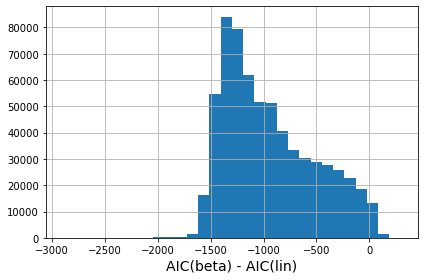

In [29]:
(df['AIC_b'] - df['AIC_l'] ).hist(bins=30)
plt.xlabel('AIC(beta) - AIC(lin)',fontsize=14)
plt.tight_layout()
plt.show()

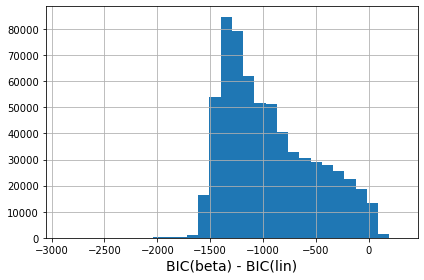

In [31]:
(df['BIC_b'] - df['BIC_l'] ).hist(bins=30)
plt.xlabel('BIC(beta) - BIC(lin)',fontsize=14)
plt.tight_layout()
plt.show()